In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import os
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
# Define some constants that we will use
PROJECT_PATH = '/home/ubuntu/projects/kaggle-predict-future-sales'

# Can set this to False to use the memory-intensive set of features
USE_LOW_MEMORY_VERSION = True

TRAIN = 'train'
VALID = 'valid'
TEST = 'test'

In [3]:
# Read in raw CSV files

csv_data = dict()

# Import all csv file data
csv_data[ 'sales_daily' ] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/sales_train.csv') )
csv_data['item_cat'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/item_categories.csv') )
csv_data['item'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/items.csv') )
csv_data['sub'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/sample_submission.csv') )
csv_data['shops'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/shops.csv') )
csv_data['test'] = pd.read_csv( os.path.join( PROJECT_PATH, 'input/test.csv') )

In [4]:
# Add some new columns and aggregate from daily to monthly
############################################################

# Add the daily revenue
csv_data['sales_daily'][ "revenue" ] = csv_data['sales_daily'].item_price * csv_data['sales_daily'].item_cnt_day

# Aggregate the monthly data
agg_rules = {'item_price' : "mean", "revenue" : "sum", "item_cnt_day" : "sum" }
groupby_cols = [ 'date_block_num', "item_id", "shop_id" ]

# Add the effective item price
csv_data['sales_monthly'] = csv_data['sales_daily'].groupby( groupby_cols ).agg( agg_rules ).reset_index()

# Rename the column to reflect monthly data
csv_data['sales_monthly'].rename( columns={ 'item_cnt_day' : 'item_cnt_month'}, inplace=True )

# Add unit price as a column
csv_data['sales_monthly']['item_price_unit'] = np.round( csv_data['sales_monthly']['revenue'] / \
                              ( 1e-6 + csv_data['sales_monthly']['item_cnt_month'] ) )


In [116]:
# Get all combinations of shops/items for each date
############################################################

df_monthly = csv_data['sales_monthly']

# Only use last 13 months if we are trying to save memory
if USE_LOW_MEMORY_VERSION:
    dates = df_monthly['date_block_num'].unique()[-13:]
else:
    dates = df_monthly['date_block_num'].unique()

# Loop through the dates and append each shop/item combination
df_id = pd.DataFrame( [], columns=['date_block_num', 'shop_id', 'item_id'])
for dt in dates:
    df_t = df_monthly[ df_monthly['date_block_num'] == dt ]
    uniq_shops = df_t['shop_id'].unique()    
    uniq_items = df_t['item_id'].unique()
        
    new_rows = pd.DataFrame( itertools.product( [dt], uniq_shops, uniq_items ), columns=df_id.columns )
    df_id = pd.concat( [ df_id, new_rows ], sort=False, axis=0 )

# Join the test IDs to the data frame
df_t = csv_data['test'].copy()
df_t['date_block_num'] = 1 + df_id['date_block_num'].max()
df_id = pd.concat( [ df_id, df_t ], sort=False, axis=0 ).drop(['ID'], axis=1)

# Create a data frame using all the shop/item pairs from each month
df_sales = df_id.merge( csv_data['sales_monthly'], on=['date_block_num', 'shop_id', 'item_id' ], how='left' )

# Set missing values for revenue and item count to 0
df_sales.loc[ np.isnan(df_sales['revenue']), ['revenue'] ] = 0
df_sales.loc[ np.isnan(df_sales['item_cnt_month']), ['item_cnt_month'] ] = 0

# Make sure values are still NaN for the test period ('date_block_num' == 34)
df_sales.loc[ df_sales['date_block_num'] == 34, 'revenue' ] = np.nan
df_sales.loc[ df_sales['date_block_num'] == 34, 'item_cnt_month' ] = np.nan

In [117]:
# Add new columns to the data frame
############################################################

# Add the category id
df_sales = df_sales.merge( csv_data['item'], on='item_id' )
df_sales = df_sales.drop('item_name', axis=1 )

# Add a column combining shop and item, which together with date_block_num is a unique id
df_sales['shop_item_id'] = df_sales['shop_id'] + 100 * df_sales['item_id']

# Add the month
df_sales['month'] = 1 + (df_sales['date_block_num'] % 12)

# Rename the target column and make it the first column
target = df_sales.loc[:,['item_cnt_month']]
target.columns = [ 'TARGET']
df_sales = pd.concat( [ target, df_sales.drop('item_cnt_month', axis=1) ], axis=1 ) 


In [118]:
%%time
# Make time series out of the monthly  sales
pivot_columns = [ 'shop_id', 'item_id']
target_col = 'item_cnt_month'
grp_table = csv_data['sales_monthly'].groupby( [ 'date_block_num' ] + pivot_columns ).agg( { target_col : 'sum' } ).reset_index()
ts_sales_raw = grp_table.pivot_table( target_col, index="date_block_num", columns=pivot_columns )

# Set negative values to 0
ts_sales_raw = np.maximum( 0, ts_sales_raw )

# Make sure the dates are sorted
ts_sales_raw.sort_index(axis=0, ascending=True, inplace=True )

# Create a version that has missing values filled with 0
ts_sales = ts_sales_raw.fillna(0)

# Downcast both versions
ts_sales_raw = ts_sales_raw.astype('float32')
ts_sales = ts_sales.astype('float32')

CPU times: user 2.18 s, sys: 268 ms, total: 2.45 s
Wall time: 2.45 s


In [119]:
%%time
# Initialize a list to store features. We will concatenate these afterwards with hstack
feature_vals = []
feature_names = []

# Just keep the last M months of observations, and convert to a numpy column vector
process_features = lambda x : x.to_numpy().ravel()[:,np.newaxis]

# Add the 'date_block_num' as a feature
ts_dates = np.tile( np.array(ts_sales.index)[:,np.newaxis], ts_sales.shape[1] )
feature_vals.append( process_features(pd.DataFrame(ts_dates) ) )
feature_names.append( 'date_block_num' )

# Add 'shop_item_id' as a feature
for j, col in enumerate(ts_sales.columns.names):
    ts = np.array([ x[j] for x in ts_sales.columns ] * ts_sales.shape[0]).reshape( ts_sales.shape[0], ts_sales.shape[1])
    feature_vals.append( process_features(pd.DataFrame(ts) ) )  
    feature_names.append( col )
    
if USE_LOW_MEMORY_VERSION:
    # Add 1-month lagged sales
    ts = ts_sales.copy()
    feature_vals.append( process_features(ts) )
    feature_names.append( 'sales_lag_01' )
    
    # Add 6-month mean rolling sales
    ts = ts_sales.rolling(window=6).mean()
    feature_vals.append( process_features(ts) )    
    feature_names.append( 'sales_mean_06' )
    
    # Add 12-month mean rolling sales
    ts = ts_sales.rolling(window=12).mean()
    feature_vals.append( process_features(ts) )    
    feature_names.append( 'sales_mean_12' )    
else:
    # Get lagged monthly sales
    print( 'Calculating lagged sales...')
    lags = np.arange(1,13)
    for L in lags:
        ts = ts_sales.shift(periods=L-1)
        feature_vals.append( process_features(ts) )
        feature_names.append( 'sales_lag_{:02}'.format(L) )

    # Get lagged monthly mean sales
    print( 'Calculating rolling mean sales...')
    means = [3, 6, 9, 12]
    for M in means:
        ts = ts_sales.rolling(window=M).mean()
        feature_vals.append( process_features(ts) )    
        feature_names.append( 'sales_mean_{:02}'.format(M) )

    # Get 12-month standard deviation
    print( 'Calculating std. dev. of sales...')
    means = [6, 12]
    for M in means:
        ts = ts_sales.rolling(window=M).std()
        feature_vals.append( process_features(ts) )
        feature_names.append( 'sales_std_{:02}'.format(M) )

    # Get the 12-month quartiles
    print( 'Calculating quantiles of sales...')
    for p in [ 0.25, 0.50, 0.75]:
        ts = ts_sales.rolling(window=12).quantile(p)
        feature_vals.append( process_features(ts) )    
        feature_names.append( 'sales_percentile_{:02}_12'.format(int(p * 100) ) )

CPU times: user 10.3 s, sys: 800 ms, total: 11.1 s
Wall time: 11.1 s


In [120]:
# Downcast floats and ints to 32-bit to save memory
################################################################

def downcast_dataframe( df ):
    for col in df.columns:
        if isinstance( df[col ].iloc[0], np.float64 ) or isinstance( df[col ].iloc[0], float ):
            df[col] = df[col].astype('float32')
        elif isinstance( df[col ].iloc[0], np.int64 ) or isinstance( df[col ].iloc[0], int ):
            df[col] = df[col].astype('int32')
            
    return df


In [121]:
def get_months_since_first_and_last_observation( input_ts ):
    """Gets the number of months since the first and last observation in each columns, 
    at each point in time. This function has no 'look-forward' bias."""
    
    # Create an array with the index (0 to T) of any non-zeros entries
    month_of_obs = input_ts.to_numpy() * np.arange(1,input_ts.shape[0]+1)[:,np.newaxis]
    month_of_obs = month_of_obs.astype('float32')
    month_of_obs[ np.less( month_of_obs, 0.1, where=~np.isnan(month_of_obs)) ] = np.nan

    # Make a data frame
    df_month_of_obs = pd.DataFrame( month_of_obs, columns=input_ts.columns)

    # Loop through the time steps and find the months since first/last action at each t
    months_since_first_obs = np.nan * np.ones_like(month_of_obs)
    months_since_last_obs = np.nan * np.ones_like(month_of_obs)
    for t in range( month_of_obs.shape[0] ):
        months_since_first_obs[t,:] = t - df_month_of_obs.iloc[:(t+1),:].idxmin(axis=0)
        months_since_last_obs[t,:] = t - df_month_of_obs.iloc[:(t+1),:].idxmax(axis=0)    

    # Fill NaN's with 999 for shop/items that have never seen a sale
    months_since_first_obs[ np.isnan( months_since_first_obs ) ] = 999
    months_since_last_obs[ np.isnan( months_since_last_obs ) ] = 999

    # Convert back into pandas Dataframe
    months_since_first_obs = pd.DataFrame( months_since_first_obs, columns=ts_sales.columns )
    months_since_last_obs = pd.DataFrame( months_since_last_obs, columns=ts_sales.columns )
    
    return months_since_first_obs, months_since_last_obs


In [122]:
%%time
# Get the number of months since the first and last sale, at each point in time
months_since_first_sale, months_since_last_sale = \
        get_months_since_first_and_last_observation( ts_sales_raw )

# Add to features
feature_vals.append( process_features( months_since_first_sale.astype('float32') ) )
feature_names.append( 'months_since_first_sale' )
feature_vals.append( process_features( months_since_last_sale.astype('float32') ) )
feature_names.append( 'months_since_last_sale' )

CPU times: user 1min 3s, sys: 984 ms, total: 1min 4s
Wall time: 1min 4s


In [123]:
%%time 
# Join the features into a pandas data frame
features_list = [ x for x in feature_vals ]
df_calc = pd.DataFrame( np.hstack(features_list), columns=feature_names)

# We must shift the date_block_num forward by 1 for the calculated columns, 
#    since these are not available until the next month
df_calc['date_block_num'] = 1 + df_calc['date_block_num'].values


CPU times: user 1.08 s, sys: 436 ms, total: 1.52 s
Wall time: 1.52 s


In [255]:
%%time
# Combine the sales data with the calculated features
df_full = df_sales.merge( df_calc, on=['date_block_num', 'shop_id', 'item_id' ], how='left' )
df_full = downcast_dataframe(df_full)

# Only use the last few periods if we are trying to save memory
if USE_LOW_MEMORY_VERSION:
    df_full = df_full[ df_full['date_block_num'] >= 31 ]
else:
    df_full = df_full[ df_full['date_block_num'] >= 22 ]

# Clean up missing values in the calculated columns
calc_sales_cols = list( df_calc.columns[ [ x.startswith('sales_') for x in df_calc.columns ] ] )
df_full[calc_sales_cols] = df_full[calc_sales_cols].fillna(0)

# Add features for months since first/last sale of a shop/item pair
df_full['months_since_first_sale'] = df_full['months_since_first_sale'].fillna(999).values
df_full['months_since_last_sale'] = df_full['months_since_last_sale'].fillna(999).values

# Add a binary feature that describes whether a shop/item pair is active
df_full['shop_item_never_active'] = ( df_full['months_since_first_sale'] == 999 ).astype('int32')
df_full['shop_item_inactive'] = ( df_full['months_since_last_sale'] > 12 ).astype('int32')

# Create a new column representing the total sales over the past 12 months
df_full['sales_total_12'] = 12 * df_full['sales_mean_12']

CPU times: user 11.5 s, sys: 2.98 s, total: 14.5 s
Wall time: 14.5 s


In [256]:
# Add additional grouped features 
#############################################

def create_group_features( df, group_col, agg_rule, target_col, new_col_name=None ):
    if new_col_name is None:
        new_col_name = target_col + '_' + agg_rule + '_by_' + group_col 
        
    vals = df_full.groupby( [ 'date_block_num', group_col ] )[ target_col ].transform(agg_rule)
    df[new_col_name] = vals.astype('float32')    
    return df

In [257]:
%%time

# Add additional categorical features
#############################################

# Create a new column representing the total sales over the past 12 months
df_full['sales_total_12'] = 12 * df_full['sales_mean_12']

for target_col in [ 'sales_lag_01', 'sales_total_12' ]:
    for agg_rule in [ 'sum', 'mean' ]:
        for group_col in [ 'item_id', 'shop_id', 'item_category_id' ]:
            df_full = create_group_features( df_full, group_col, agg_rule, target_col )

for group_col in [ 'item_id', 'shop_id', 'item_category_id']:
    df_full = create_group_features( df_full, group_col, 'min', 'months_since_first_sale', \
                                    new_col_name='min_months_since_first_sale_for_' + group_col.replace('_id', '') )
    df_full = create_group_features( df_full, group_col, 'min', 'months_since_last_sale', \
                                    new_col_name='min_months_since_last_sale_for_' + group_col.replace('_id', '') )
    
    df_full = create_group_features( df_full, group_col, 'mean', 'shop_item_never_active', \
                                    new_col_name=group_col.replace('_id', '') +'_mean_never_active' )
    df_full = create_group_features( df_full, group_col, 'mean', 'shop_item_inactive', \
                                    new_col_name=group_col.replace('_id', '') +'_mean_inactive' )


CPU times: user 1.66 s, sys: 348 ms, total: 2.01 s
Wall time: 2 s


In [258]:
# Define the base set of features that will be used for training and validation
########################################################################

# Drop the revenue and price columns
df_base = df_full.drop( [ 'item_price', 'item_price_unit', 'revenue' ], axis=1 )

# Only keep the past 12 periods for testing
df_base = downcast_dataframe( df_base )

In [268]:
# Save the raw features to a HDF5 file
print( 'File size: {:02} MB'.format( np.round( df_base.memory_usage().sum() / 1e6 ) ) )
#file_name = os.path.join( PROJECT_PATH, 'preprocessed_data/base_features.h5')
#df_base.to_hdf(file_name, key='base_features')     

File size: 145.0 MB


In [206]:
# Read in the raw features from a HDF5 file
# file_name = os.path.join( PROJECT_PATH, 'preprocessed_data/raw_features.h5')
# df_full = pd.read_hdf(file_name, key='raw_features')

In [260]:
import seaborn as sns
import pandas as pd

def heatMap(corr, figsize=(40,40)):
    #Plot figsize
    fig, ax = plt.subplots(figsize=figsize)
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

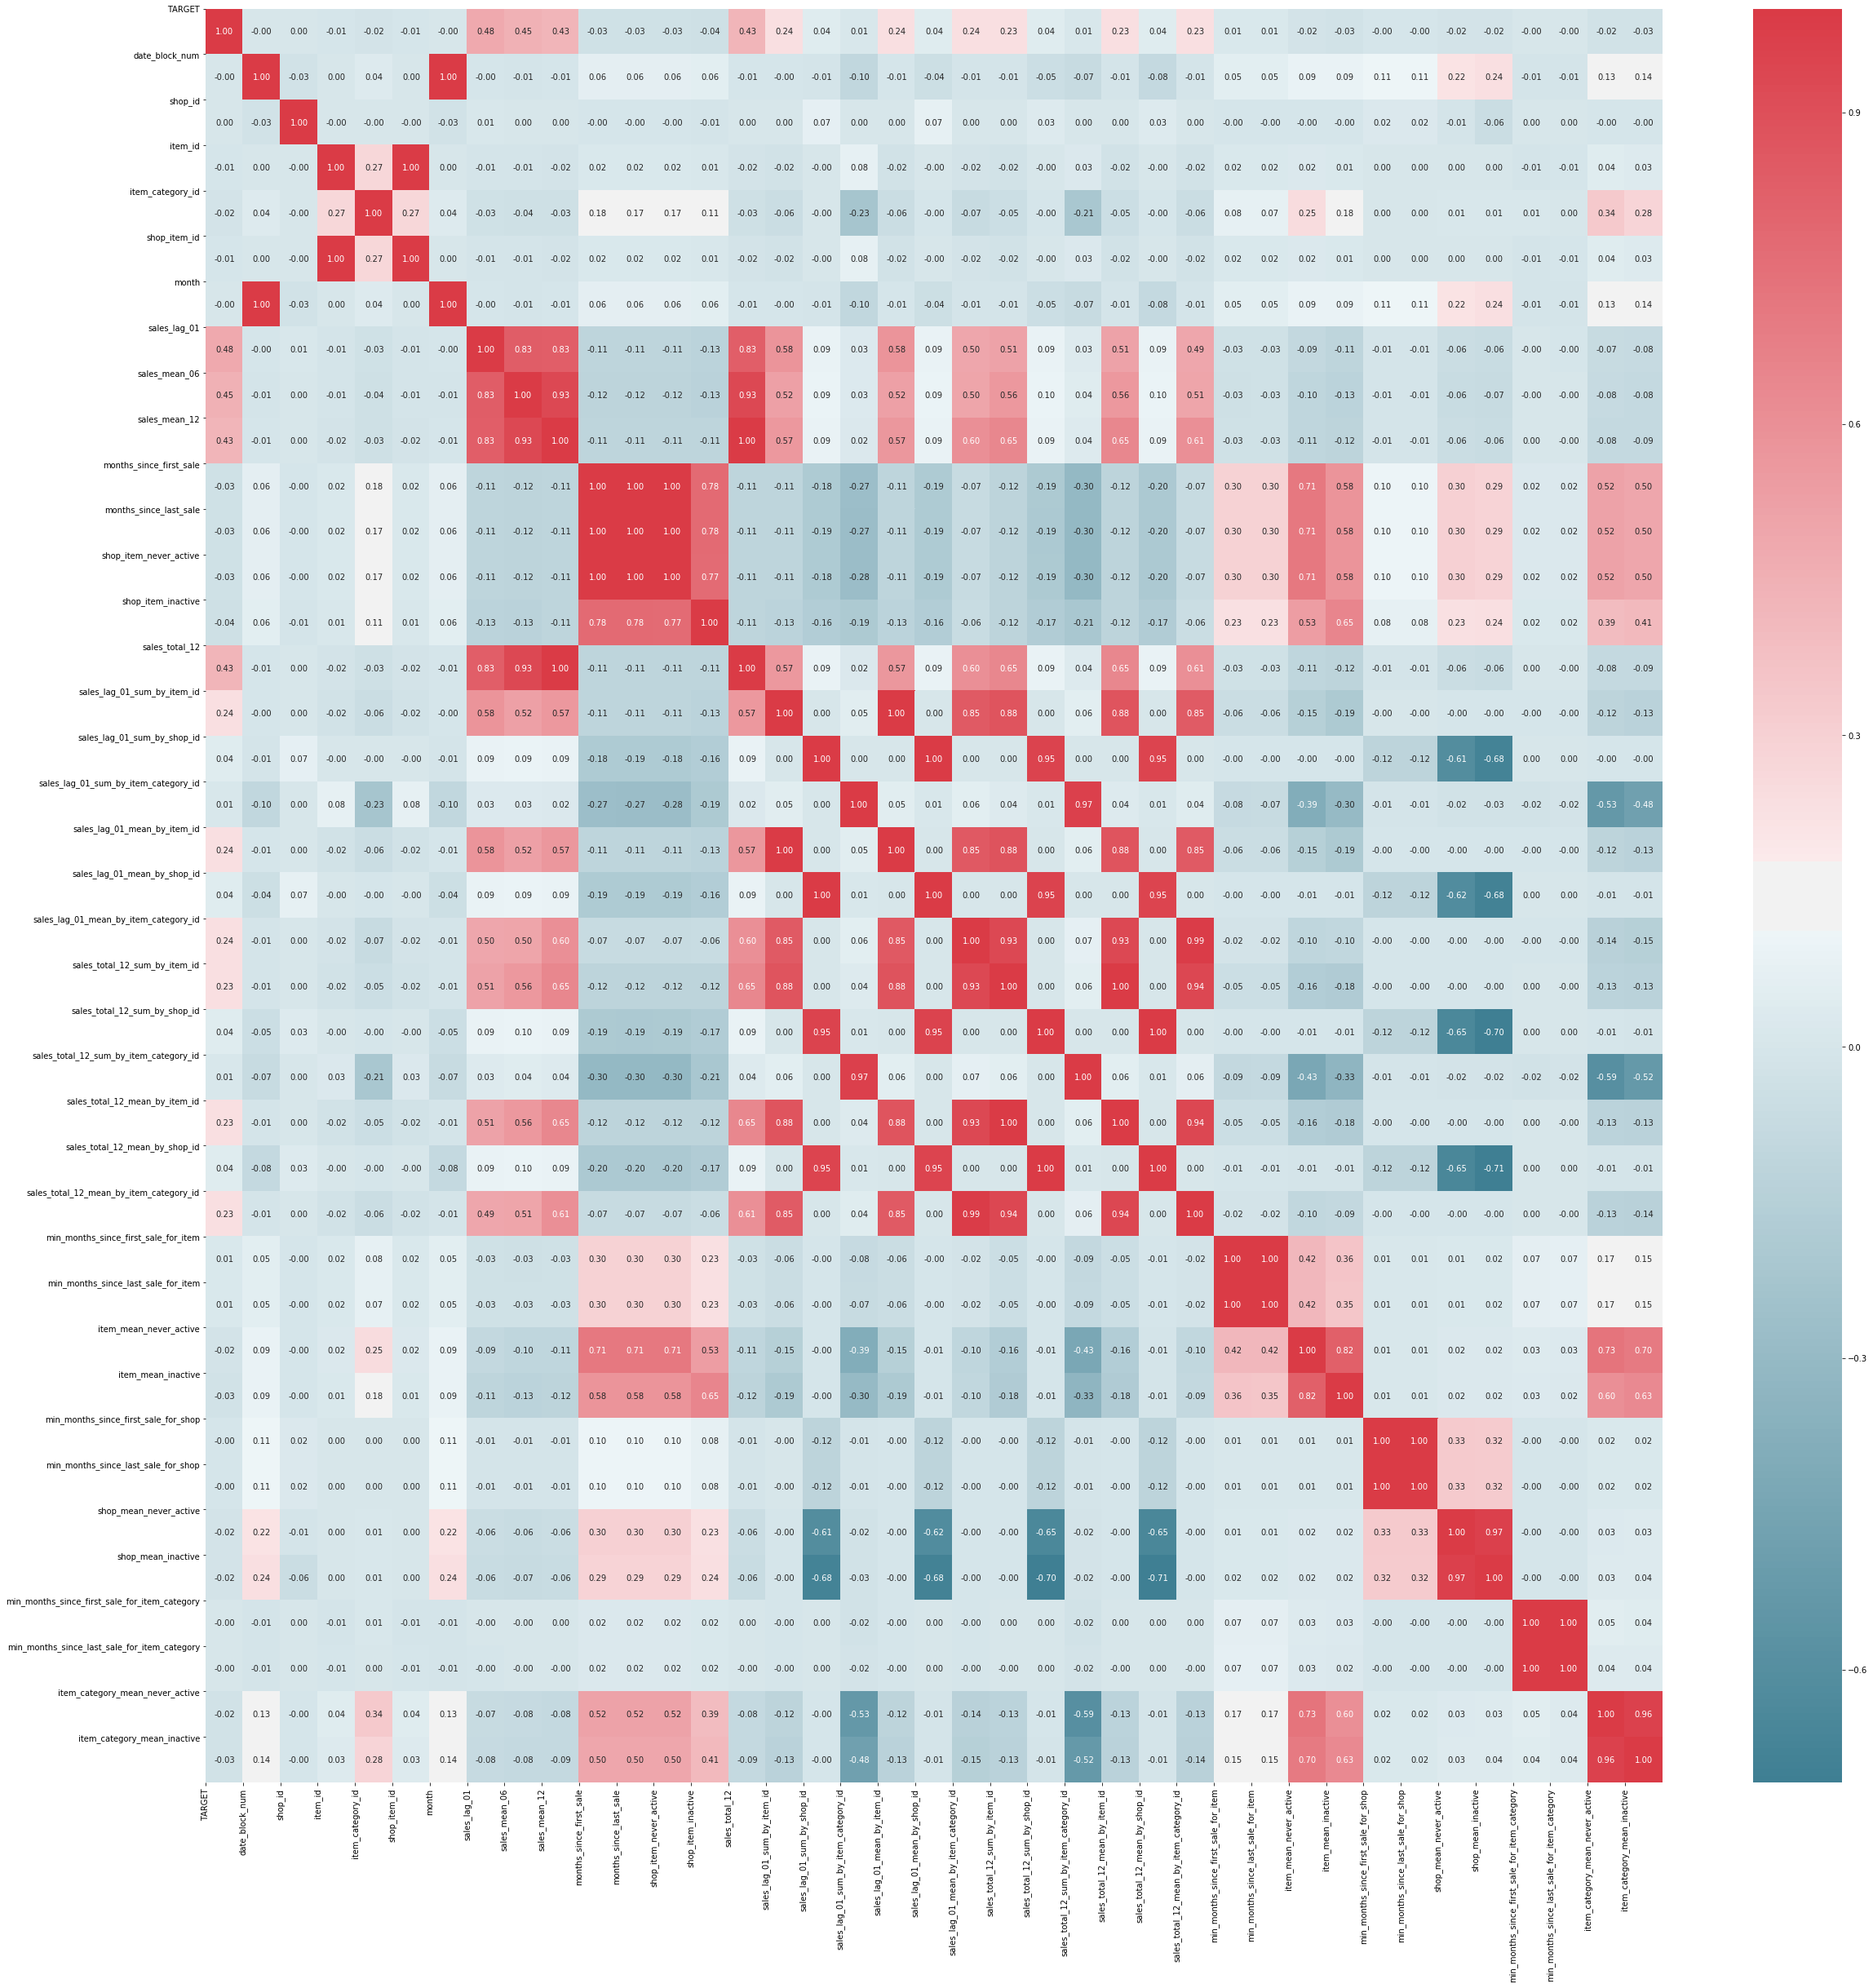

In [261]:
# Find the correlations, excluding rows with NaN values
corr = df_base[np.all( ~np.isnan( df_base ), axis=1)].corr()
heatMap(corr)

In [209]:
# Get different datasets, in chronological order
# The test set is always the next period after the end of the train set.
##########################################################################

def get_validation_set( df, idx, min_train_size ):

    date_blocks = df['date_block_num']
    uniq_date_blocks = np.sort( date_blocks.unique() )

    n_datasets = len(uniq_date_blocks) - min_train_size - 1
    if idx >= 0:
        split_date = uniq_date_blocks[min_train_size + idx]
    else:
        split_date = uniq_date_blocks[idx]    

    xtrain = df[ date_blocks < split_date].drop('TARGET', axis=1 )
    ytrain = df[ date_blocks < split_date ]['TARGET'][:,np.newaxis]
    xtest = df[ date_blocks == split_date ].drop('TARGET', axis=1 )
    ytest = df[ date_blocks == split_date ]['TARGET'][:,np.newaxis]

    return xtrain, ytrain, xtest, ytest


In [262]:
# Construct some train/validation/test data sets
##########################################################################

# Specify which Dataframe to use
features_df = df_base

if USE_LOW_MEMORY_VERSION:
    MIN_TRAIN_SIZE = 2
else:
    MIN_TRAIN_SIZE = 5

data_sets = []
for j in range(100):
    try:
        xtrain, ytrain, xtest, ytest = get_validation_set( features_df, j, min_train_size=MIN_TRAIN_SIZE )
        data_sets.append( ( xtrain, ytrain, xtest, ytest ) )
    except IndexError:
        break

In [263]:
# Define functions for mean encoding
########################################################################

from sklearn.model_selection import KFold

def encode_means_with_cv( X, y, group_col, n_splits ):

    kf = KFold(n_splits=n_splits, shuffle=True)
    split_info = [ x for x in kf.split(X) ]

    if isinstance( y, np.ndarray ):
        # Make sure the target values are a 1-d array
        y = y.ravel()
        
    mu = np.nanmean( y )
    encoded_feature = pd.Series( np.nan * np.ones_like(y), index = X[group_col] )

    for splt in split_info:
        # Get the test and train indices for the current fold
        idx_train, idx_test = splt

        # Get the test and train data
        X_train = X.iloc[idx_train,:]
        y_train = y[idx_train]
        X_test = X.iloc[idx_test,:]
        y_test = y[idx_test]

        # Put the means into the output vector
        data = ( X_train, y_train, X_test, y_test )
        encoded_feature.iloc[idx_test] = encode_means_from_test_train_split( data, group_col )

    # Fill missing values with the global mean
    encoded_feature = encoded_feature.fillna(mu)
    
    return encoded_feature


def encode_means_from_test_train_split( data, group_col):
    
    # expand the input train/test data (we don't ever use the TARGET value from the test set 'y_test')
    X_train, y_train, X_test, _ = data
    
    # Combine the TARGET column and features together
    train_data = pd.concat( [X_train, pd.DataFrame( y_train, index=X_train.index.values, columns=['TARGET'] ) ], axis=1 )
    test_data = X_test
        
    # Get item IDs common to both test and train, and also those just found in the test set
    common_ids = set(test_data[group_col]).intersection( set(train_data[group_col]) )
    missing_ids = set(test_data[group_col]).difference(common_ids)

    # Construct a dictionary mapping item IDs from the test set to their means in the train set
    train_means = train_data.groupby(group_col)['TARGET'].mean()    
    common_means = pd.Series( [ train_means[x] for x in list(common_ids) ], index=pd.Index(common_ids, dtype='int64' ) )
    missing_means = pd.Series( np.nan * np.ones_like(missing_ids), index=pd.Index(list(missing_ids), dtype='int32' ) )
    all_means = dict(pd.concat( [ common_means, missing_means ] ) )

    encoded_features_test = [ all_means[x] for x in test_data[group_col] ]    
    return encoded_features_test    


In [264]:
n_splits = 5
group_cols = [ 'item_id', 'shop_id', 'item_category_id', 'shop_item_id', 'date_block_num', 'month' ]

for j in range(len(data_sets)):
    
    ds_j = data_sets[j]
    X_train, y_train, X_test, y_test = ds_j
    
    for group_col in group_cols:

        new_col_name = 'TARGET' + '_mean_' + group_col
        print('Encoding mean on dataset {} for column {}...'.format(j, new_col_name ) )

        if new_col_name not in X_train:
            X_train[new_col_name] = encode_means_with_cv( X_train, y_train, group_col, n_splits ).to_numpy()

        if new_col_name not in X_test:
            X_test[new_col_name] = encode_means_from_test_train_split( ds_j, group_col=group_col)

    # Update the datasets with the mean encoded column
    data_sets[j] = ( X_train, y_train, X_test, y_test) 

Encoding mean on dataset 0 for column TARGET_mean_item_id...
Encoding mean on dataset 0 for column TARGET_mean_shop_id...
Encoding mean on dataset 0 for column TARGET_mean_item_category_id...
Encoding mean on dataset 0 for column TARGET_mean_shop_item_id...
Encoding mean on dataset 0 for column TARGET_mean_date_block_num...
Encoding mean on dataset 0 for column TARGET_mean_month...
Encoding mean on dataset 1 for column TARGET_mean_item_id...
Encoding mean on dataset 1 for column TARGET_mean_shop_id...
Encoding mean on dataset 1 for column TARGET_mean_item_category_id...
Encoding mean on dataset 1 for column TARGET_mean_shop_item_id...
Encoding mean on dataset 1 for column TARGET_mean_date_block_num...
Encoding mean on dataset 1 for column TARGET_mean_month...
